In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
rootPath = '/content/gdrive/My Drive/Dataset/GarbageClassification/'
classNames = sorted(os.listdir(rootPath))
nClasses = len(classNames)
print(f"Number of Classes : {nClasses}")

Number of Classes : 6


In [3]:
import numpy as np 
import pandas as pd 
for dirname, _, filenames in os.walk('/content/gdrive/My Drive/Dataset/GarbageClassification/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/gdrive/My Drive/Dataset/GarbageClassification/paper/paper342.jpg
/content/gdrive/My Drive/Dataset/GarbageClassification/paper/paper215.jpg
/content/gdrive/My Drive/Dataset/GarbageClassification/paper/paper485.jpg
/content/gdrive/My Drive/Dataset/GarbageClassification/paper/paper286.jpg
/content/gdrive/My Drive/Dataset/GarbageClassification/paper/paper578.jpg
/content/gdrive/My Drive/Dataset/GarbageClassification/paper/paper113.jpg
/content/gdrive/My Drive/Dataset/GarbageClassification/paper/paper462.jpg
/content/gdrive/My Drive/Dataset/GarbageClassification/paper/paper217.jpg
/content/gdrive/My Drive/Dataset/GarbageClassification/paper/paper361.jpg
/content/gdrive/My Drive/Dataset/GarbageClassification/paper/paper24.jpg
/content/gdrive/My Drive/Dataset/GarbageClassification/paper/paper36.jpg
/content/gdrive/My Drive/Dataset/GarbageClassification/paper/paper419.jpg
/content/gdrive/My Drive/Dataset/GarbageClassification/paper/paper10.jpg
/content/gdrive/My Drive/Dataset/GarbageC

In [4]:
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
    
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.83.195.170:8470


REPLICAS:  8


In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('font', family = 'D2coding')
plt.rc('axes', unicode_minus = False)

In [6]:
import shutil, pathlib

In [7]:
os.chdir('/content/gdrive/My Drive/Dataset/GarbageClassification/')
os.getcwd()

'/content/gdrive/My Drive/Dataset/GarbageClassification'

In [10]:
original_dir = pathlib.Path('/content/gdrive/My Drive/Dataset/GarbageClassification/')
new_base_dir = pathlib.Path('/content/gdrive/My Drive/Dataset/GarbageClassificationGAIP/')
def make_subset_train():
    for category in ('cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'):
        dir = new_base_dir / 'train' / category
        os.makedirs(dir)
        fnames = [f'{category}{i}.jpg'
                  for i in range(1, len(os.listdir(original_dir / category)) // 10 * 9)]
        for fname in fnames:
            shutil.copyfile(src = original_dir / category /fname,
                            dst = dir / fname) 
             
def make_subset_test():
    for category in ('cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'):
        dir = new_base_dir / 'test' / category
        os.makedirs(dir)
        fnames = [f'{category}{i}.jpg'
                  for i in range((len(os.listdir(original_dir / category)) // 10) * 9,
                                 len(os.listdir(original_dir / category)) + 1)]
        for fname in fnames:
            shutil.copyfile(src = original_dir / category /fname,
                            dst = dir / fname)         

In [11]:
make_subset_train()
make_subset_test()

In [11]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Conv2D, MaxPooling2D

inputs  = keras.Input(shape = (300, 300, 3))
x = layers.Conv2D(filters = 32, kernel_size = 3, use_bias = False, padding = 'same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, use_bias = False, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 32, kernel_size = 3, use_bias = False, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 32, kernel_size = 3, use_bias = False, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation = 'softmax')(x)
model = keras.Model(inputs = inputs, outputs = outputs)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 32)      864       
                                                                 
 batch_normalization (BatchN  (None, 300, 300, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 300, 300, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      18432 

In [13]:
model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

In [14]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)
train_generator = train_datagen.flow_from_directory(
                '/content/gdrive/My Drive/Dataset/GarbageClassificationGAIP/train',
                target_size = (300, 300),
                batch_size = 16,
                class_mode = 'categorical')

# validation_datagen = ImageDataGenerator(rescale = 1./255)
# validation_generator = train_datagen.flow_from_directory(
#                 '/content/gdrive/My Drive/Dataset/GarbageClassificationGAIP/validation',
#                 target_size = (300, 300),
#                 batch_size = 16,
#                 class_mode = 'categorical')

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(
                '/content/gdrive/My Drive/Dataset/GarbageClassificationGAIP/test',
                target_size = (300, 300),
                batch_size = 16,
                class_mode = 'categorical')

Found 2253 images belonging to 6 classes.
Found 274 images belonging to 6 classes.


In [15]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / 'train',
    image_size = (180, 180),
    batch_size = 32)
# validation_dataset = image_dataset_from_directory(
#     new_base_dir / 'validation',
#     image_size = (180, 180),
#     batch_size = 32)
test_dataset = image_dataset_from_directory(
    new_base_dir / 'test',
    image_size = (180, 180),
    batch_size = 32)

Found 2253 files belonging to 6 classes.
Found 274 files belonging to 6 classes.


In [16]:
for data_batch, labels_batch in train_generator:
    print('1 :', data_batch.shape)
    print('2 :', labels_batch.shape)
    break

1 : (16, 300, 300, 3)
2 : (16, 6)


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = '/content/gdrive/My Drive/Dataset/ConvertFromScratch.keras',
        save_best_only = True,
        monitor = 'val_loss')
    ]
history = model.fit(
    train_generator,
    epochs = 30, 
    validation_data = test_generator,
    callbacks = callbacks)

Epoch 1/30
141/141 [==============================] - 592s 4s/step - loss: 1.4756 - accuracy: 0.4683 - val_loss: 2.6758 - val_accuracy: 0.1861
Epoch 2/30
141/141 [==============================] - 483s 3s/step - loss: 1.1708 - accuracy: 0.5810 - val_loss: 2.3965 - val_accuracy: 0.2007
Epoch 3/30
141/141 [==============================] - 481s 3s/step - loss: 1.0437 - accuracy: 0.6298 - val_loss: 1.9746 - val_accuracy: 0.3066
Epoch 4/30
 58/141 [===========>..................] - ETA: 4:38 - loss: 0.9060 - accuracy: 0.6681

In [ ]:
test_model = keras.models.load_model('/content/gdrive/My Drive/Dataset/ConvertFromScratch.keras')
test_loss, test_acc = test_model.evaluate(test_generator)
print(f'A: {test_acc:.3f}')

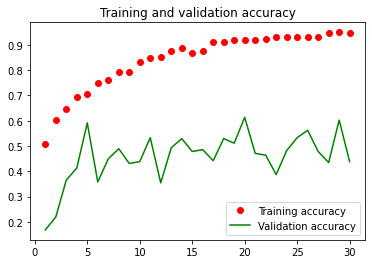

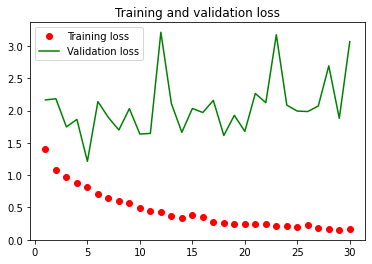

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'ro', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'g', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label = 'Training loss')
plt.plot(epochs, val_loss, 'g', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


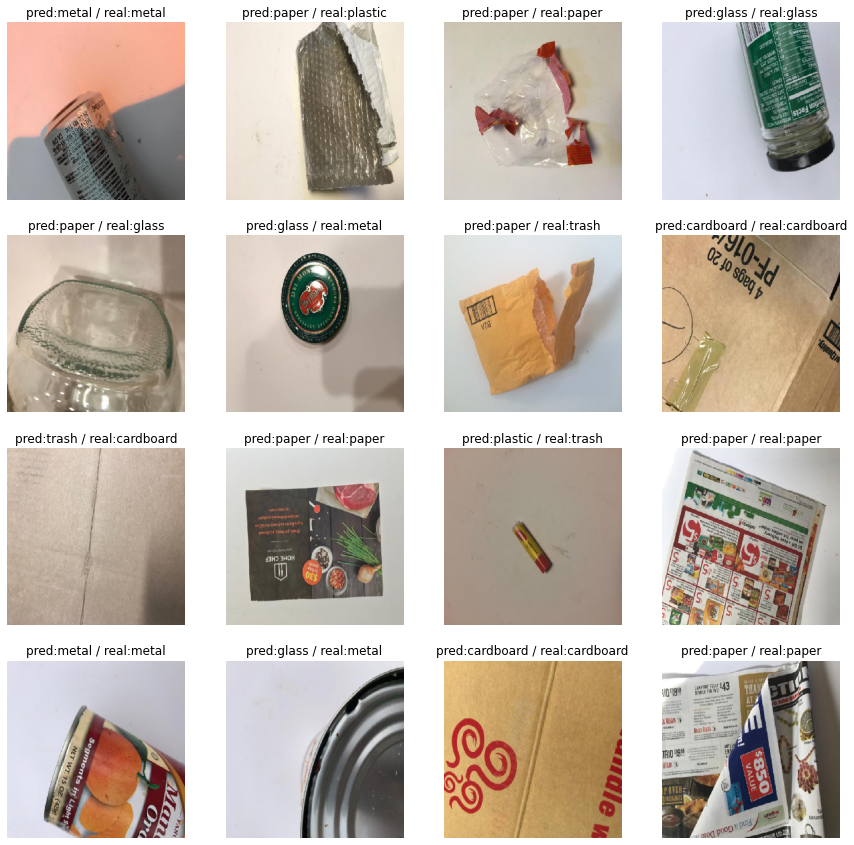

In [ ]:
test_x, test_y = test_generator.__getitem__(1)
preds = test_model.predict(test_x)

plt.figure(figsize=(15, 15))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / real:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])
    plt.axis('off')

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   horizontal_flip = True,
                                  vertical_flip = True, 
                                  shear_range=0.1,
                                  zoom_range=0.1,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  validation_split=0.1)

train_generator = train_datagen.flow_from_directory(
                '/kaggle/working/Garbage_classification_small/train',
                target_size = (300, 300),
                batch_size = 16,
                class_mode = 'categorical')

test_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.1)

test_generator = test_datagen.flow_from_directory(
                '/kaggle/working/Garbage_classification_small/test',
                target_size = (300, 300),
                batch_size = 16,
                class_mode = 'categorical')

Found 2253 images belonging to 6 classes.
Found 274 images belonging to 6 classes.


In [ ]:
inputs  = keras.Input(shape = (300, 300, 3))
x = layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same')(inputs)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation = 'softmax')(x)
model = keras.Model(inputs = inputs, outputs = outputs)

In [ ]:
model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = '/kaggle/working/convert_from_scratch_with_augmentation.keras',
        save_best_only = True,
        monitor = 'val_loss')
    ]

history = model.fit_generator(
    train_generator,
    epochs = 60, 
    validation_data = test_generator,
    callbacks = callbacks)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-12-16 15:25:50.234009: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2022-12-16 15:25:52.130056: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


141/141 [==============================] - 54s 327ms/step - loss: 1.6792 - accuracy: 0.3285 - val_loss: 1.6561 - val_accuracy: 0.2737
Epoch 2/60
141/141 [==============================] - 49s 344ms/step - loss: 1.5291 - accuracy: 0.3959 - val_loss: 1.7090 - val_accuracy: 0.2409
Epoch 3/60
141/141 [==============================] - 47s 333ms/step - loss: 1.4592 - accuracy: 0.4336 - val_loss: 1.9656 - val_accuracy: 0.3321
Epoch 4/60
141/141 [==============================] - 47s 331ms/step - loss: 1.4174 - accuracy: 0.4279 - val_loss: 1.4530 - val_accuracy: 0.4015
Epoch 5/60
141/141 [==============================] - 47s 331ms/step - loss: 1.3526 - accuracy: 0.4669 - val_loss: 2.9121 - val_accuracy: 0.2372
Epoch 6/60
141/141 [==============================] - 47s 333ms/step - loss: 1.4024 - accuracy: 0.4434 - val_loss: 22.7007 - val_accuracy: 0.1606
Epoch 7/60
141/141 [==============================] - 46s 328ms/step - loss: 1.3188 - accuracy: 0.4869 - val_loss: 1.5275 - val_accuracy: 0.

In [ ]:
test_model = keras.models.load_model('/kaggle/working/convert_from_scratch_with_augmentation.keras')
test_loss, test_acc = test_model.evaluate(test_generator)
print(f'테스트 정확도 : {test_acc:.3f}')

18/18 [==============================] - 1s 61ms/step - loss: 1.0466 - accuracy: 0.6679
테스트 정확도 : 0.668


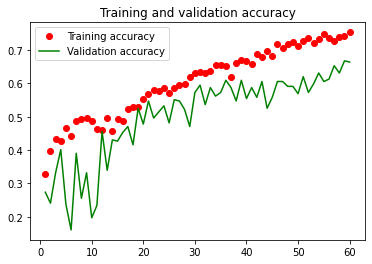

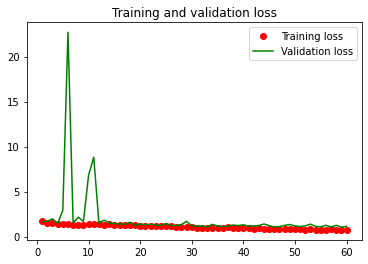

In [ ]:
import matplotlib.pyplot as plt


accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'ro', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'g', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label = 'Training loss')
plt.plot(epochs, val_loss, 'g', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

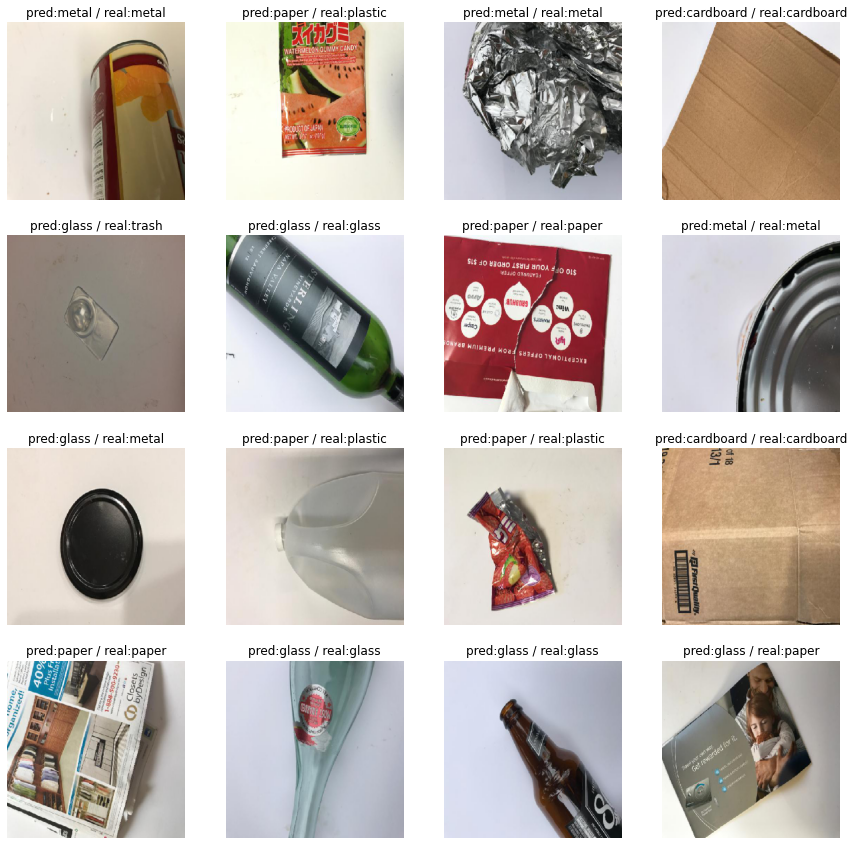

In [ ]:
test_x, test_y = test_generator.__getitem__(1)
preds = test_model.predict(test_x)

plt.figure(figsize=(15, 15))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / real:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])
    plt.axis('off')